# eqGAN Training Notebook

An attempt to perform automatic music mastering using a Generative Adversarial Network

### Make sure that these constants are set correctly!

In [1]:
# Constants
USING_GPU = True
AVAILABLE_GPUS="0,1,2,3,4,5"
CUDANO = 0

D_LR = 1e-3
G_LR = 1e-3
EPOCHS = 10
IS_DIRECT = False # Direct or Indirect Reconstruction (See Paper for more details)
SAMPLE_LENGTH = 110229 # Less than 661794


RUN_NAME = 'cnn_gan_run_2'

You should (hopefully) be able to run the rest of the cells without editing anything

In [2]:
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import numpy as np

/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download the dataset

In [3]:
# Construct a torch.utils.data.Dataset and DataLoader
gtzan_data = torchaudio.datasets.GTZAN('.', download=False)

def collate_fn(batch):
    # Takes in a list (batch) of samples (waveform, sample_rate, label)
    batch_size = len(batch)
    waveforms = []
    for waveform, sample_rate, label in batch:
        if waveform.size(1) == 661794:
            waveforms.append(waveform)
        elif waveform.size(1) > 661794:
            waveforms.append(waveform[:,:661794])
        else:
            diff = 661794 - waveform.size(1)
            waveforms.append(torch.nn.functional.pad(waveform,(0,diff)))
            
        
    waveform_batch = torch.stack(waveforms, dim=0)
    # Returns a tuple collated with sizes (torch.Size([batch_size, 1, 661794]), )
    return waveform_batch, sample_rate, label

gtzan_loader = torch.utils.data.DataLoader(gtzan_data, batch_size=10, shuffle=False, num_workers=6, collate_fn=collate_fn)

In [4]:
def visualize_wav(waveform, domain='time'):
    """
    A function to visualize a waveform in the time or frequency domain
    """
    wav = torch.squeeze(waveform, dim=0)
    if domain == 'freq':
        plt.figure(figsize=(50,30))
        specgram = torchaudio.transforms.Spectrogram()(wav)
        plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
    elif domain == 'time':
        plt.figure()
        plt.plot(wav.t().numpy())
    else:
        print('Invalid domain')

Shape of waveform: torch.Size([10, 1, 661794])
Sample rate of waveform: 22050


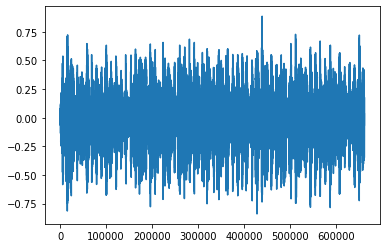

In [5]:
# Show a single example
example_wav, example_sr = None, None
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))
    example_wav, example_sr = waveform[0,:,:], sample_rate

    visualize_wav(waveform[0,:,:])
    break

### Implement EQ operations

In [6]:
# Define the EQ transform
from scipy.stats import loguniform

class RandomEQ(object):
    """EQ the waveform in a sample randomly.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, sample_rate):
        assert isinstance(sample_rate, (float, int))
        self.sample_rate = sample_rate
        
        # EQ Constants
        self.FREQ_RANGE = [0.01, 20] # in kHZ
        self.GAIN_RANGE = [-15, 15] # in dB
        self.Q_RANGE = [0.1, 18]

    def __call__(self, waveform, verbose=False):
        # TODO: Make some of these normals
        center_freq = loguniform.rvs(self.FREQ_RANGE[0], self.FREQ_RANGE[1])
        gain = np.random.uniform(self.GAIN_RANGE[0], self.GAIN_RANGE[1])
        Q = np.random.uniform(self.Q_RANGE[0], self.Q_RANGE[1])

        center_freq = 1
        gain = -10
        Q = 1
        
        if verbose:
            print(
                f"Applying random EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

        equalized_waveform = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        ) 

        return equalized_waveform

Shape of waveform: torch.Size([10, 1, 661794])
Sample rate of waveform: 22050


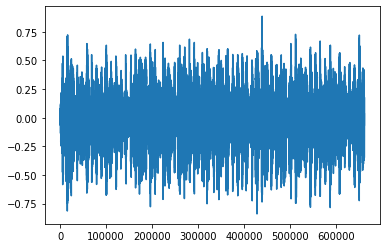

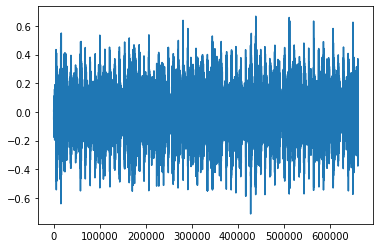

In [7]:
# Show a single example
eq_transform = RandomEQ(example_sr)
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    visualize_wav(waveform[0,:,:])
    visualize_wav(eq_transform(waveform[0,:,:]))
    break

### Learn an EQ operation

We want to test whether or not we can have a model learn an EQ operation by reconstructing the non-equalized version of the waveform

In [8]:
import os

device = 'cpu'

if USING_GPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=AVAILABLE_GPUS
    device = f'cuda:{CUDANO}'

if not os.path.exists(f"EQ/{RUN_NAME}"):
    os.mkdir(f"EQ/{RUN_NAME}")

In [9]:
import torch.fft as fft

class EQReconstructor(torch.nn.Module):
    def __init__(self, sample_rate, sample_length, direct=False):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        
        # Params
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.direct = direct
        self.indirect = not direct

        # Audio transforms
        self.synthetic_transform = RandomEQ(self.sample_rate)       
        self.specgram = torchaudio.transforms.Spectrogram()
        
        # CNN Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7, padding=3) #p = (f-1)/2
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=7, padding=3)
        self.fc1 = torch.nn.Linear(100 * 276, 120)
        self.fc2 = torch.nn.Linear(120, SAMPLE_LENGTH)

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, apply a random
        EQ, and then try to reconstruct it.
        
        Params:
            waveform is an audio wav of shape [batch_size, 1, length]
        """
        # print("Pre-processing wav")
        #print(f"waveform.shape: {waveform.shape}")
        with torch.no_grad():
            equalized_wav = self.synthetic_transform(waveform)
            
        # Turn audio into spectrogram
        specgram = self.specgram(equalized_wav) #torch.Size([batch_size, 1, 201, 552])
        
        # Run spectrogram through CNN 
        x = specgram
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.pool(torch.nn.functional.relu(x))

        if self.direct:
            # Generate output spectrogram
            # Turn output spectrogram back into audio
            reconstructed_wav = waveform

        if self.indirect:
            # Use output to generate a filter kernel
            x = x.view(-1, 100 * 276)
            x = torch.nn.functional.relu(self.fc1(x))
            x = torch.nn.functional.relu(self.fc2(x))
            kernel = x.view(-1, waveform.shape[-1]) #[batch, n_frames, n_impulse_response] n_f * n_imp = waveform.shape(-1) [110,229]
            
            # Apply the filter kernel
            #print(f"equalized_wav.shape: {equalized_wav.shape}")
            signal = torch.nn.functional.pad(equalized_wav, (0, equalized_wav.shape[-1]))
            #print(f"signal.shape: {signal.shape}")
            kernel = torch.nn.functional.pad(kernel, (kernel.shape[-1], 0))
            #print(f"kernel.shape: {kernel.shape}")

            output = fft.irfft(fft.rfft(signal) * fft.rfft(kernel))
            #print(f"output.shape: {output.shape}")
            output = output[..., output.shape[-1] // 2:]
            output = torch.unsqueeze(output[:,0,:],dim=-2)
            #print(f"output.shape: {output.shape}")
            
            reconstructed_wav = output
            
        return reconstructed_wav

In [10]:
criterion = torch.nn.MSELoss()
def loss_function(output, waveform):
    """
    Here we define the loss function that the model will try to optimize.
    In this case, a simple reconstruction loss
    """
    reconstructed_wav = output
    loss = criterion(waveform, reconstructed_wav)
    return loss

In [11]:
class EQEvaluator(torch.nn.Module):
    def __init__(self, sample_rate, sample_length):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        
        # Params
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        
        # Audio transforms
        self.specgram = torchaudio.transforms.Spectrogram()
        
        # CNN Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7, padding=3) #p = (f-1)/2
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=1, kernel_size=7, padding=3)
        self.fc1 = torch.nn.Linear(100 * 276, 120)
        self.fc2 = torch.nn.Linear(120, 1)

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, run it through
        an LSTM, and decide if it's mastered or unmastered
        """
        
        # Turn audio into spectrogram
        specgram = self.specgram(waveform) #torch.Size([batch_size, 1, 201, 552])
        
        # Run spectrogram through CNN 
        x = specgram
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.pool(torch.nn.functional.relu(x))
        
        # Use output to generate the final prediction
        x = x.view(-1, 100 * 276)
        x = torch.nn.functional.relu(self.fc1(x))
        logit = torch.nn.functional.relu(self.fc2(x))
        
        return logit

In [12]:
checkpoint_path = f'./{RUN_NAME}.pt'

In [13]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    generator = EQReconstructor(
        sample_rate=checkpoint["hyperparameters"]["sample_rate"],
        sample_length=checkpoint["hyperparameters"]["sample_length"],
        direct=checkpoint["hyperparameters"]["direct"]
    ).to(f'cuda:{CUDANO}')
    discriminator = EQEvaluator(
        sample_rate=checkpoint["hyperparameters"]["sample_rate"],
        sample_length=checkpoint["hyperparameters"]["sample_length"]
    ).to(f'cuda:{CUDANO}')
    if torch.cuda.device_count() > 1:
        generator = torch.nn.DataParallel(generator)
        discriminator = torch.nn.DataParallel(discriminator)
    gen_optimizer = torch.optim.SGD(generator.parameters(), lr=checkpoint['hyperparameters']['lr'])
    disc_optimizer = torch.optim.SGD(discriminator.parameters(), lr=checkpoint['hyperparameters']['lr'])
    generator.load_state_dict(checkpoint['models']['generator'])
    discriminator.load_state_dict(checkpoint['models']['discriminator'])
    gen_optimizer.load_state_dict(checkpoint['optimizers']['generator'])
    disc_optimizer.load_state_dict(checkpoint['optimizers']['discriminator'])
    
    return generator, discriminator, gen_optimizer, disc_optimizer, checkpoint

In [14]:
generator, discriminator, gen_optimizer, disc_optimizer, checkpoint = load_checkpoint(checkpoint_path)

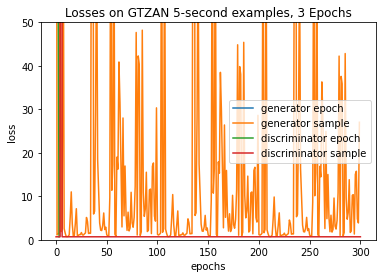

In [20]:
for modelname in checkpoint['losses'].keys():
    for lossname in checkpoint['losses'][modelname]:
        plt.plot(checkpoint['losses'][modelname][lossname], label=f'{modelname} {lossname}')

plt.title(f"Losses on GTZAN 5-second examples, {checkpoint['epochs']} Epochs")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.ylim(0, 50)
plt.savefig(f"gtzan_5_sec_{checkpoint['epochs']}_epochs_losses.png")    